In [5]:
SMALL_SIZE, MEDIUM_SIZE = 9, 12
PROJECT_PATH = "/Users/donghur/Desktop/Research/Murthy/BM_GPU"
PROJECT_PATH_BMGPU = "/Users/donghur/Desktop/Research/Murthy/BM_GPU"

In [2]:
import sys
import numpy as np
from glob import glob
import random, matplotlib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

sys.path.append(PROJECT_PATH)
from utils.data import Dataset


In [3]:
import utils.figure as ufigure
%load_ext autoreload
%autoreload 1
%aimport utils.data
%aimport utils.figure

In [6]:
config_path = f"{PROJECT_PATH_BMGPU}/config_ant.yaml"
Data = Dataset(PROJECT_PATH, config_path)
Data.load_data()

Loading config.yaml ...
Finished loading config
Loading INFO.yaml ...
Finished loading INFO


100%|██████████| 141/141 [00:31<00:00,  4.45it/s]


In [7]:
# configuration
INFO = Data.info
INFO_values = Data.info_values
config = Data.config
skeleton = config['skeleton']
skeleton_color= config['skeleton_color']

# features
bp = Data.data_obj['bodypoints']
rot_bp = Data.data_obj['rotated_bodypoints']
angles = Data.data_obj['angles']
limbs = Data.data_obj['limbs']
angle_power = Data.data_obj['angle_power']
limb_power = Data.data_obj['limb_power']

# embeddings
all_embed = Data.data_obj['all_embeddings']
all_postural_embed = Data.data_obj['all_postural_embeddings']
all_kinematic_embed = Data.data_obj['all_kinematic_embeddings']

<hr>
<hr>

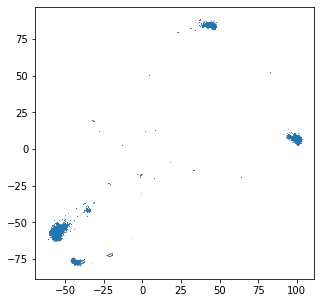

In [8]:
fig_all_embed, ax_all_embed = plt.subplots(1,1,figsize=(5,5))
ax_all_embed.scatter(all_embed[:,0], all_embed[:,1], s=1, alpha=0.005)
plt.show()

<hr>
<hr>

In [9]:
# Global parameter for the rest of the embeddings
ax_x_length = np.diff(ax_all_embed.get_xlim())[0]
ax_y_length = np.diff(ax_all_embed.get_ylim())[0]

def fix_aspect_ratio(xlim, ylim):
    d = np.diff(xlim)[0]*ax_y_length/ax_x_length - np.diff(ylim)[0]
    return xlim, (ylim[0]-d/2, ylim[1]+d/2)

def plot_embedding(embed, xlim, ylim, frac_pts=1/3, scatter_s=1, scatter_alpha=0.04, kde_gridsize=200):
    num_fr = len(embed)
    idx = random.choices(np.arange(num_fr), k=int(num_fr*frac_pts))
    
    # Scatter Plot
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].scatter(embed[idx,0], embed[idx,1], s=scatter_s, alpha=scatter_alpha)
    ax[0].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", xlim=xlim,ylim=ylim)

    # Density Plot
    sns.kdeplot(x=embed[idx,0], y=embed[idx,1], 
                shade=True, thresh=0, gridsize=kde_gridsize, bw_adjust=0.3,
                levels=100, cmap='viridis',
                cbar=False, ax=ax[1])
    ax[1].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", facecolor='#440054', 
                        xlim=xlim ,ylim=ylim)
    plt.show()

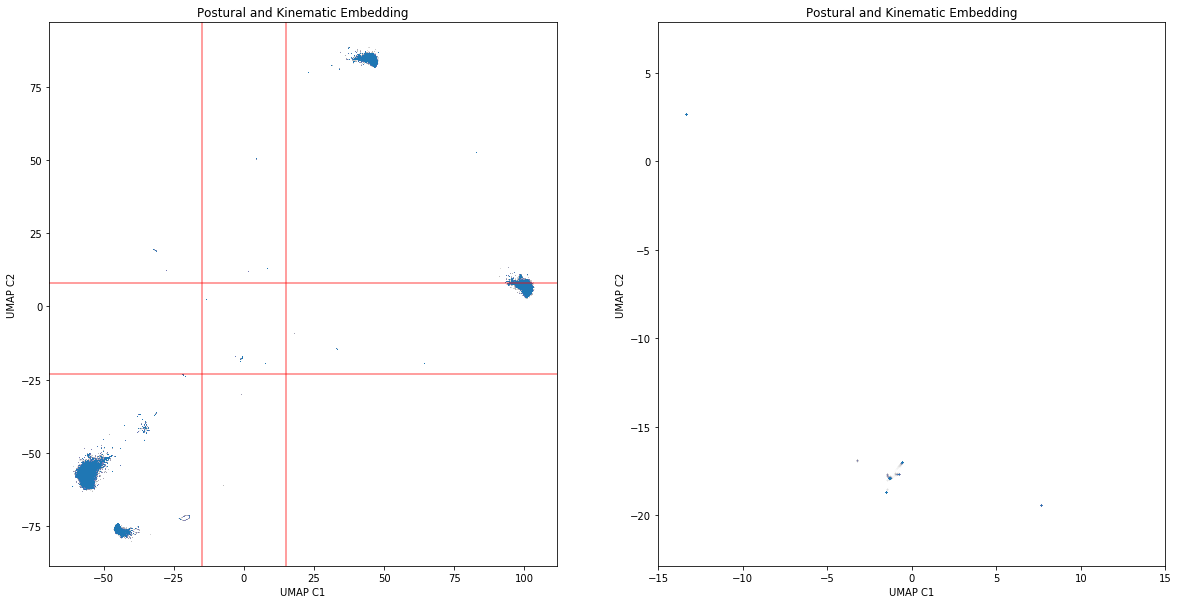

In [10]:
region_x_lim, region_y_lim = (-15,15), (-20,5)
region_x_lim, region_y_lim = fix_aspect_ratio(region_x_lim, region_y_lim)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].scatter(all_embed[:,0], all_embed[:,1], s=1, alpha=0.005)
ax[0].set(xlabel="UMAP C1", ylabel="UMAP C2", title="Postural and Kinematic Embedding")
for x,y in zip(region_x_lim, region_y_lim):
    ax[0].axhline(y=y, color='r', alpha=0.5)
    ax[0].axvline(x=x, color='r', alpha=0.5)
ax[1].scatter(all_embed[:,0], all_embed[:,1], s=1.5, alpha=0.002)
ax[1].set(xlabel="UMAP C1", ylabel="UMAP C2", title="Postural and Kinematic Embedding",xlim=region_x_lim, ylim=region_y_lim)
plt.show()

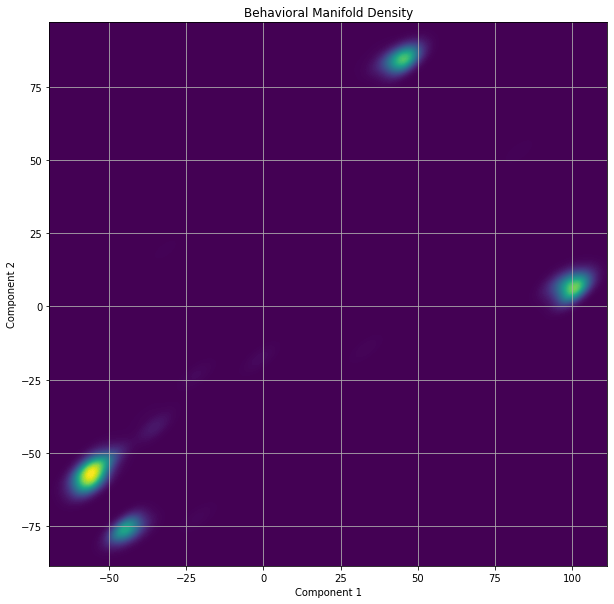

In [12]:
import seaborn as sns

good_fr, _ = np.where(~np.isnan(all_embed))

fig_dense, ax_density = plt.subplots(figsize=(10, 10))
sns.kdeplot(x=all_embed[good_fr,0], y=all_embed[good_fr,1], 
            shade=True, thresh=0, gridsize=300, bw_adjust=0.5,
            levels=100, cmap='viridis',
            cbar=False, ax=ax_density)
ax_density.set(xlabel='Component 1', ylabel='Component 2', title="Behavioral Manifold Density", facecolor='#440054', xlim=ax_all_embed.get_xlim(), ylim=ax_all_embed.get_ylim())
ax_density.grid(which="major")
plt.show()

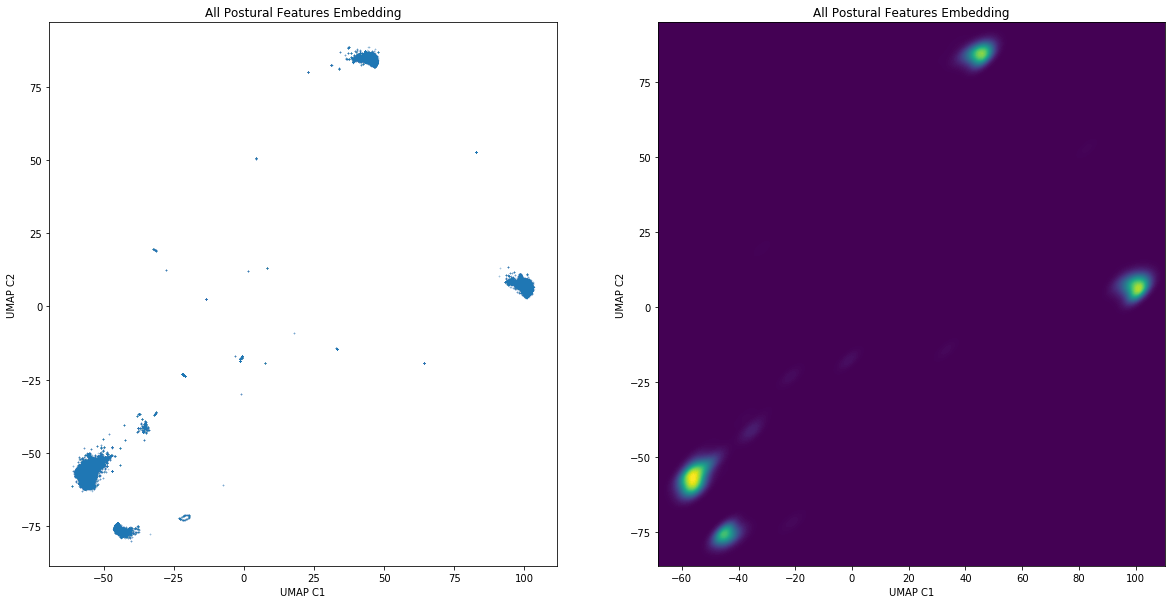

In [13]:
### Region 1
# find figure bounds
region_x_lim, region_y_lim = None, None #(-4,8.5), (-6.5,3)
# region_x_lim, region_y_lim = fix_aspect_ratio(region_x_lim, region_y_lim)

# plot region 1
plot_embedding(all_embed, region_x_lim, region_y_lim, frac_pts=1/2, 
               scatter_s=1, scatter_alpha=0.025, 
               kde_gridsize=300)

# HDBSCAN

In [21]:
# %matplotlib qt
%matplotlib inline


In [18]:
import seaborn as sns
from sklearn.utils import shuffle

from utils.figure import plot_HDBSCAN
from cluster import HDBSCAN
%aimport cluster

In [38]:
# hdbscan
labels, num_clusters, clusterer = HDBSCAN(all_embed, min_cluster_size=3000, min_samples=20, 
                               cluster_selection_epsilon=0, cluster_selection_method="leaf", 
                               memory="memory")
color_palette = sns.color_palette('rainbow', int(num_clusters))
color_palette = shuffle(color_palette, random_state=1)

Frac Outlier: 0.18805184233213576
# Clusters: 22


100%|██████████| 22/22 [00:00<00:00, 14426.94it/s]


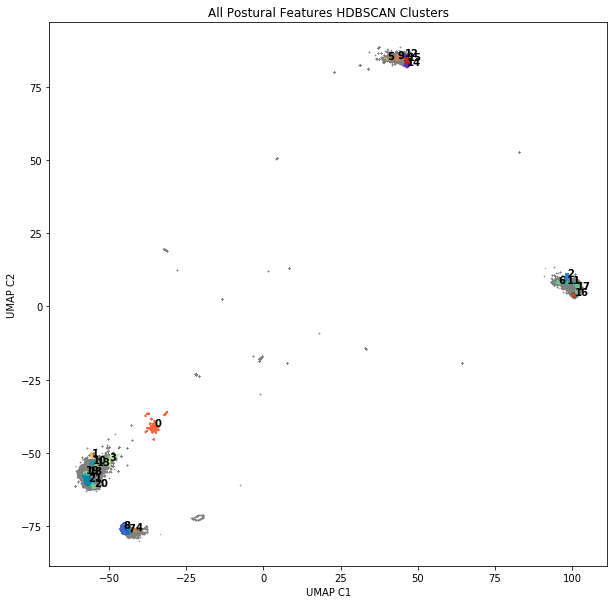

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
plot_HDBSCAN(ax, all_embed, labels, color_palette, alpha=0.02, toggle_numbering=True)
plt.show()




100%|██████████| 5/5 [00:00<00:00, 7053.99it/s]


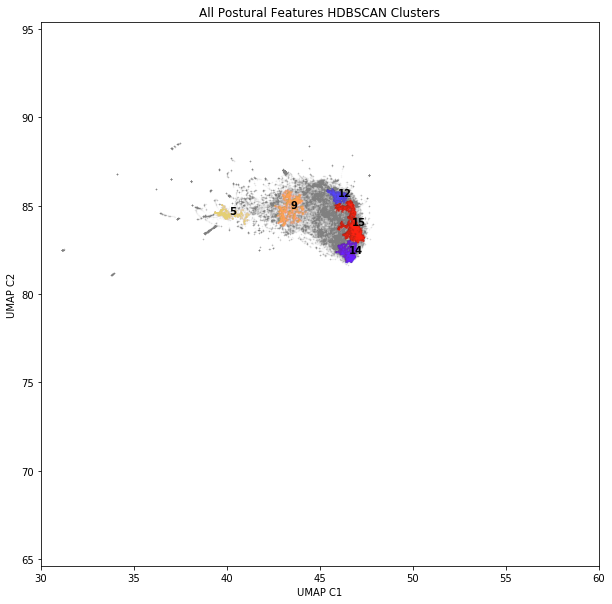

In [42]:
region_x_lim, region_y_lim = (30,60), (60,100)
region_x_lim, region_y_lim = fix_aspect_ratio(region_x_lim, region_y_lim)

fig, ax = plt.subplots(figsize=(10,10))
plot_HDBSCAN(ax, all_embed, labels, color_palette, alpha=0.02, xlim=region_x_lim, ylim=region_y_lim, toggle_numbering=True)
plt.show()

100%|██████████| 12/12 [00:00<00:00, 10170.06it/s]


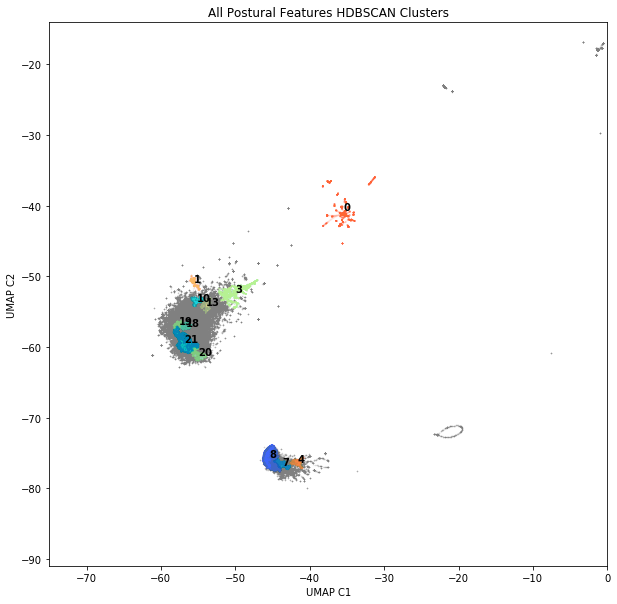

In [43]:
region_x_lim, region_y_lim = (-75,0), (-80,-25)
region_x_lim, region_y_lim = fix_aspect_ratio(region_x_lim, region_y_lim)

fig, ax = plt.subplots(figsize=(10,10))
plot_HDBSCAN(ax, all_embed, labels, color_palette, alpha=0.02, xlim=region_x_lim, ylim=region_y_lim, toggle_numbering=True)
plt.show()

100%|██████████| 5/5 [00:00<00:00, 7481.81it/s]


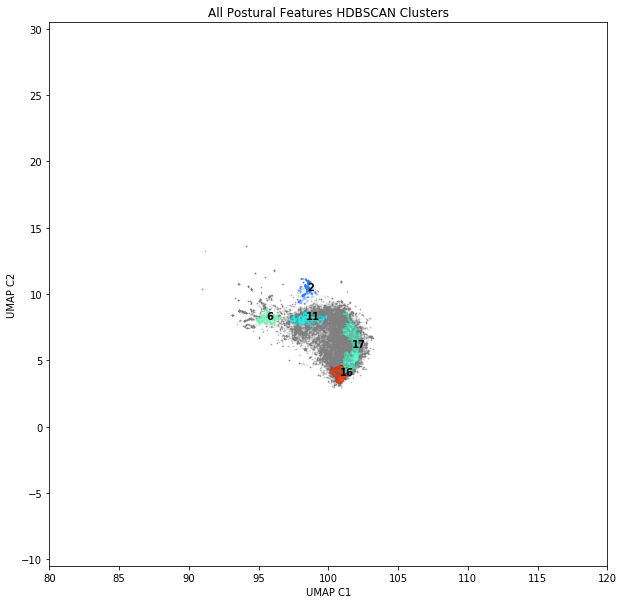

In [44]:
region_x_lim, region_y_lim = (80,120), (-5,25)
region_x_lim, region_y_lim = fix_aspect_ratio(region_x_lim, region_y_lim)

fig, ax = plt.subplots(figsize=(10,10))
plot_HDBSCAN(ax, all_embed, labels, color_palette, alpha=0.02, xlim=region_x_lim, ylim=region_y_lim, toggle_numbering=True)
plt.show()

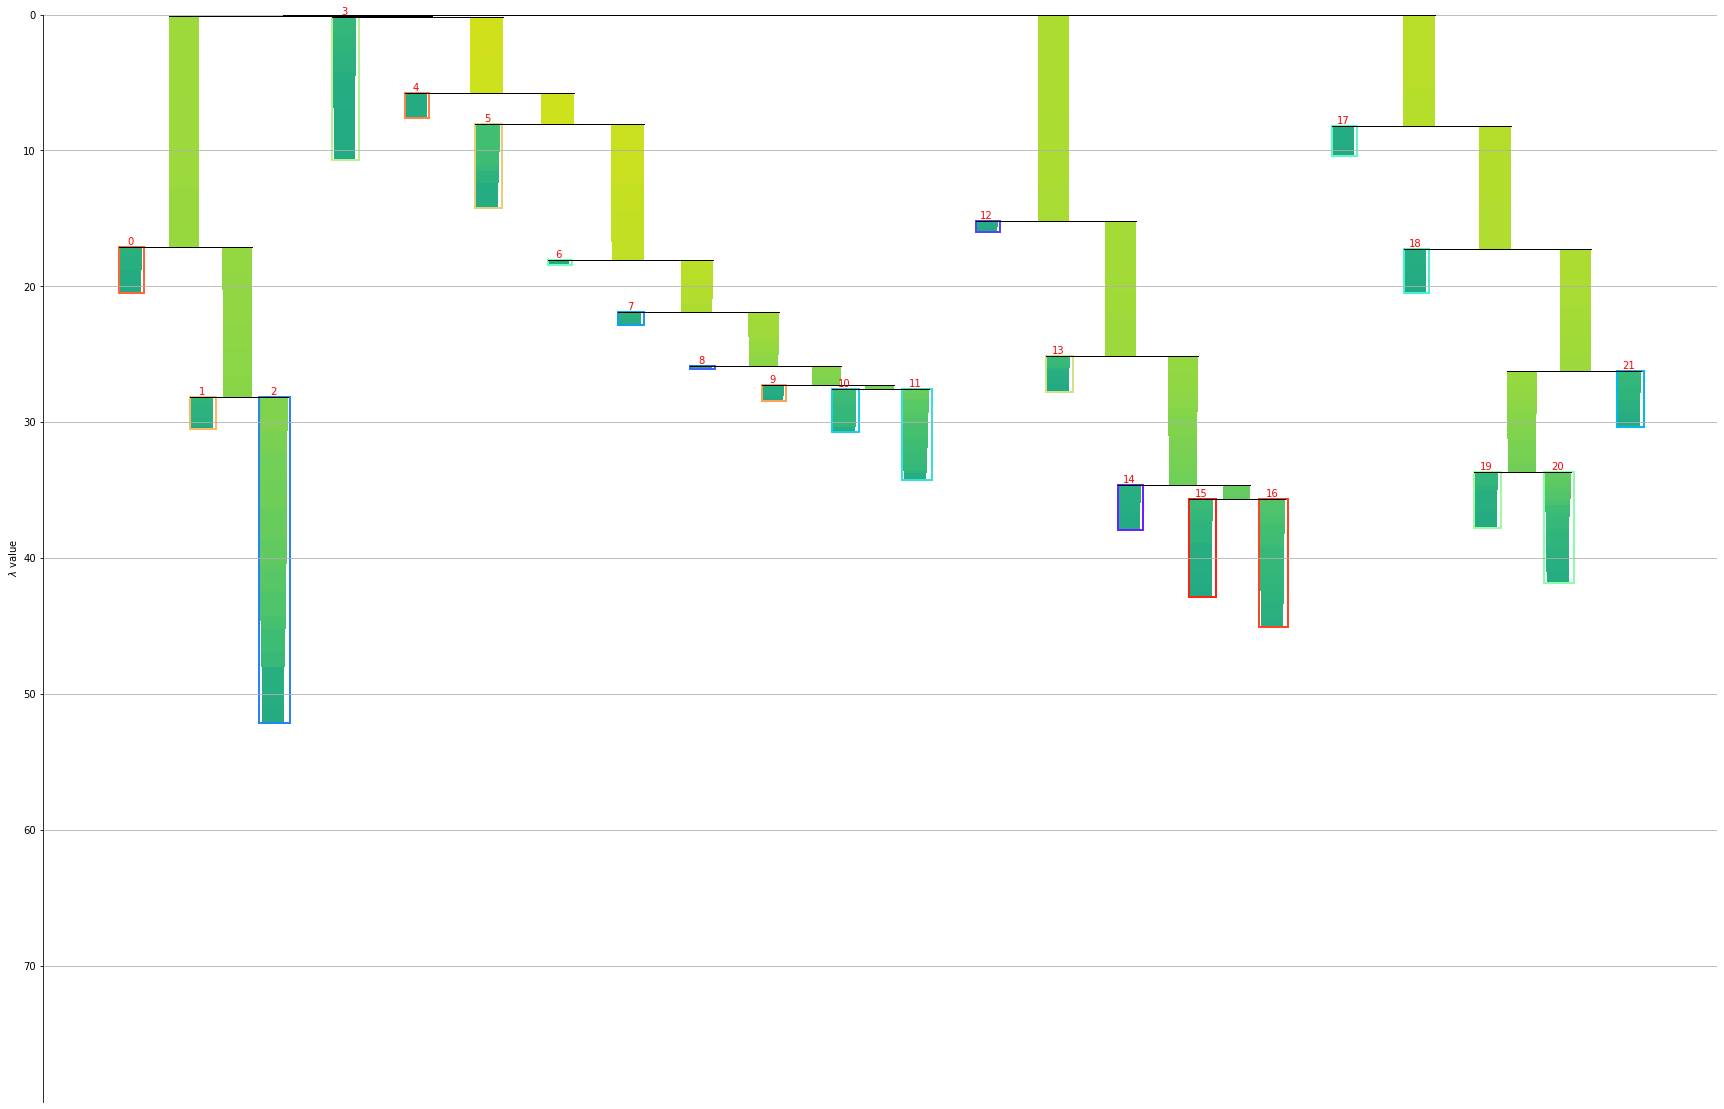

In [45]:
fig, ax = plt.subplots(figsize=(30,20))
ax.set(ylim=(0,80), yticks=np.arange(0,80,10))
clusterer.condensed_tree_.plot(leaf_separation=2,
                               label_clusters=True,
                               log_size=True,
                               colorbar=False,
                               select_clusters=True,
                               selection_palette=color_palette,
                               axis=ax)
ax.grid(axis='y')

# Save HDBSCAN Cluster

In [50]:
import os
for val in INFO_values:
    start_fr, stop_fr = val['global_start_fr'], val['global_stop_fr']
    save_path = f"/Users/donghur/Desktop/Research/Murthy/BM_GPU_cluster/{val['directory']}"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    np.save(f"{save_path}/cluster.npy", labels[start_fr:stop_fr])

In [47]:
PROJECT_PATH

'/Users/donghur/Desktop/Research/Murthy/BM_GPU'

In [48]:
val['directory']

'results/final/06TTminfr_antmovie200927204039'

In [55]:

test = 2

In [56]:
if (test ==0) | (test ==1):
    print('hello')